# [Computational Social Science]
## 5-4 word2vec - Solutions

In this lab we will use the techniques we introduce word embeddings via word2vec.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

In [ ]:
# download and install new libraries -- WILL NEED TO UNCOMMENT AND RUN ONLY FIRST 
# ----------
!pip install gensim
!pip install tqdm
!pip install adjustText
!pip install multiprocessing - ONLY NECESSARY ON OLD VERSIONS OF PYTHON (BEFORE 2.6)

In [1]:
# load libraries
# ----------
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

from tqdm import tqdm

import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data

<img src = "../../images/cfpb_logo.png"/>

We'll once again use the Consumer Financial Protection Bureau's [Consumer Complaint Database](https://www.consumerfinance.gov/data-research/consumer-complaints/). Picking up from where we left off last time, we'll focus on predicting whether a consumer complaint narrative is talking about a "mortgage" issue or a "student loan" issue.

In [2]:
# load the data
# ----------
cfpb = pd.read_csv("data/CFPB 2020 Complaints.csv")
cfpb = cfpb.dropna(subset = ['Consumer complaint narrative'])
cfpb = cfpb[(cfpb['Product']=='Mortgage') | (cfpb['Product'] == 'Student loan')]
cfpb = cfpb[:1000].reset_index(drop = True)

## Overview <a id='context'></a>

In this lab, we will be turning individual words in the data set into vectors, called "Word Embeddings". **Word embedding** attempt to identify semantic relationships between words by observing them in the context that the word appears. `Word2Vec` is the most prominent word embedding algorithm.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” (`“Call me Ishmael"`). After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of `Word2Vec` are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. **Skip-Grams** take a word of interest as its input (e.g., "me") and tries to learn how to predict its context words ("Call", "Ishmael"). **CBOW** does the opposite, taking the context words ("Call", "Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features

* `vector_size`: Number of dimensions for word embedding model (*formerly* `size`) 
* `window`: Number of context words to observe in each direction
* `min_count`: Minimum frequency for words included in model
* `sg` (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram
* `alpha`: Learning rate (initial); prevents model from over-correcting, enables finer tuning
* `epochs`: Number of passes through dataset (*formerly* `iterations`) 
* `batch_words`: Number of words to sample from data during each pass


For more detailed background on Word2Vec's mechanics, I suggest this  <a href="https://www.tensorflow.org/text/tutorials/word2vec">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

We will be using the default value for most of our parameters.

## Preprocessing

First let's use our handy preprocessing function. Notice that this version will return a list of tokens (not a string), and we also added the `str.lower()` method.

In [3]:
# create preprocessing function - like we have in the past few labs
# ----------

def rem_punc_stop(text):
    stop_words = STOP_WORDS
    # Individually
    # nlp.Defaults.stop_words.add("XX")
    # nlp.Defaults.stop_words.add("XXXX")
    # nlp.Defaults.stop_words.add("XXXXXXX")
    
    # Using the bitwise |= (or) operator
    nlp.Defaults.stop_words |= {"xx", "xxxx","xxxxxxxx"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text.lower() for token in doc]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [4]:
# apply our preprocessing function to the consumer complaint column in our original dataframe
# ----------
cfpb['tokens'] = cfpb['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
cfpb['tokens']

0      [contacting, ocwen, mortgage, phh, mortgage, a...
1      [purchased, house, assignment, deed, trust, si...
2      [past, issues, mortgage, solutions, colorado, ...
3      [called, nationstar, multiple, times, request,...
4      [documents, short, sale, review, sent, xxxx20,...
                             ...                        
995    [contacted, offering, complete, application, l...
996    [parent, plus, loan, opened, children, start, ...
997    [tcf, refusing, provide, account, information,...
998    [asking, loan, modification, years, particular...
999    [loan, bayview, loan, services, went, 3,  , 72...
Name: tokens, Length: 1000, dtype: object

## Model Training

Now that we have pre-processed our text, we can use the [`gensim`](https://radimrehurek.com/gensim/models/word2vec.html) library to construct our word embeddings. We will use the Continous Bag of Words model (CBOW), which predicts target words from its neighboring context words to learn word embeddings from raw text.

Read through the documentation of the Word2Vec method in gensim to understand how to implement the Word2Vec model. Then fill in the blanks so that: we use a __Continuous Bag of Words__ model to create word embeddings of __vector_size 100__ for words that appear in the `text` at least __5 or more times__. Set the learning rate to .025, epochs/number of iterations to 5, and sample 10000 words from the data during each pass.

**CHALLENGE:** Go ahead and annotate each line so you know what each one is doing. 

In [5]:
# apply CBOW Word2vec model to our cfpb data 
# ----------
model = gensim.models.Word2Vec(cfpb['tokens'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000) # sample size

## Practice with Embeddings <a id='subsection 2'></a>

Now that we've trained the mode, we can return the actual high-dimensional vector by simply indexing the model with the word as the key:

In [6]:
# return embeddings for specific word
# ----------
print(model.wv.__getitem__(['account'])) # specify a key word here: "account"

[[-0.29218578  0.17060934  0.05090766  0.0191023   0.3535277  -0.6223802
   0.28982097  0.63965166 -0.10208492 -0.1951133  -0.15770951 -0.39949644
  -0.17632897  0.33764634  0.37998542 -0.15373099  0.15157692 -0.35088384
  -0.24647406 -0.83398354  0.11799937  0.04534115  0.32363856 -0.3033803
   0.09378296  0.07974382 -0.02965954 -0.17751865 -0.40414822 -0.07980406
   0.72957075  0.13899192  0.02631168 -0.24040718 -0.40755057  0.24423741
   0.02668205 -0.34961888 -0.3704906  -0.82542753  0.07647888 -0.22883886
  -0.09582517 -0.12682849  0.26677    -0.26200008 -0.22438873 -0.01715871
   0.2747027   0.2842453   0.01287812 -0.46772668 -0.22637886 -0.12320562
  -0.28658944  0.1304222   0.07732917 -0.00125013 -0.58641934  0.24425985
   0.08106656  0.16038932  0.2423163   0.06409053 -0.5134737   0.47009313
   0.11613301  0.5142928  -0.6713563   0.26967752 -0.14693941  0.46506214
   0.2316048  -0.20094918  0.2869453   0.28736672  0.17563309  0.13426957
  -0.36752987 -0.08575812 -0.24924822  0

**QUESTION:** Check out the shape of the vectors for 'account', what do you notice?

In [7]:
# get shape
# ----------
model.wv.__getitem__(['account']).shape 

(1, 100)

**ANSWER:** There are 100 elements in this array. Notice that this was one of the parameters we set in the training process!

**CHALLENGE:** Use the following empty cells to look at what the word embeddings look like for words you think may appear in the text, for example, `bank`. Keep in mind that even if a word shows up in the text as seen above, a word vector will not be created unless it satisfies all conditions we inputted into the model above. 

In [8]:
# word 1
# ----------
model.wv.__getitem__(['navient'])

array([[-0.45134872,  0.41583005,  0.14317413, -0.06453318,  0.16439965,
        -0.68860745,  0.02251586,  0.53830594, -0.07795656, -0.06214852,
        -0.37250242, -0.46719602, -0.15904218,  0.31774455,  0.2782309 ,
        -0.23763978, -0.03958273, -0.47484526, -0.29506785, -0.79424274,
         0.09431394,  0.0660475 ,  0.2429631 , -0.14669773, -0.11483131,
         0.0854366 , -0.04173327, -0.13648766, -0.5254037 , -0.03394864,
         0.64181954,  0.07895444,  0.00117489, -0.19879664, -0.34908077,
         0.31995288,  0.03072981, -0.33905965, -0.3604688 , -0.85385656,
        -0.00597283, -0.14130461, -0.31515053, -0.15181434,  0.33291996,
        -0.31277183, -0.1656747 ,  0.12103932,  0.35382652,  0.18477775,
         0.08194436, -0.43382478, -0.01915948, -0.18749103, -0.25013268,
         0.15637693, -0.01121314,  0.028119  , -0.7037263 ,  0.2273589 ,
         0.16609058,  0.2858417 ,  0.14048861,  0.06704532, -0.43121392,
         0.42170262,  0.14659882,  0.47769046, -0.6

In [9]:
# word 2
# ----------
model.wv.__getitem__(['company'])

array([[-3.31685603e-01,  2.27382481e-01,  6.73922300e-02,
         2.01674737e-03,  2.24404991e-01, -5.81752598e-01,
         1.56710953e-01,  6.04728043e-01, -9.02375802e-02,
        -1.84016347e-01, -1.86331138e-01, -5.04101932e-01,
        -1.44173771e-01,  3.39836597e-01,  2.82359779e-01,
        -5.66464253e-02,  7.29590431e-02, -3.71007383e-01,
        -3.16219628e-01, -7.60888219e-01,  1.21272318e-01,
         3.69855389e-02,  3.04552704e-01, -2.26771191e-01,
         2.40859631e-02,  5.12074381e-02,  3.77447195e-02,
        -9.05237570e-02, -4.26394045e-01, -1.72327496e-02,
         6.11837804e-01,  4.83011082e-02,  4.93610054e-02,
        -2.12169409e-01, -3.19894671e-01,  2.46168837e-01,
         6.02194965e-02, -3.57147992e-01, -3.79763752e-01,
        -7.40356922e-01, -2.65933704e-02, -1.93542436e-01,
        -1.80287540e-01, -1.13160096e-01,  2.12521613e-01,
        -3.48491877e-01, -1.15866937e-01,  4.38582152e-02,
         2.35428795e-01,  2.37468958e-01,  5.98328151e-0

In [10]:
# word 3 
# ----------
model.wv.__getitem__(['credit'])

array([[-5.9972680e-01,  4.8580000e-01,  7.4903965e-02, -3.4952324e-02,
         2.0026587e-01, -8.6890572e-01, -4.5968909e-02,  5.3042519e-01,
        -6.8513237e-02, -5.9145517e-03, -5.7227588e-01, -4.9818122e-01,
        -2.7152535e-01,  2.1602461e-01,  1.6517717e-01, -3.9398009e-01,
        -1.5052681e-01, -3.6254570e-01, -2.1935263e-01, -7.0464867e-01,
         7.4277766e-02, -1.0281533e-02,  2.5305271e-01, -2.0943204e-01,
        -1.3136327e-01,  9.9870555e-02,  1.9599939e-02,  2.1002512e-02,
        -5.5552435e-01, -1.7048815e-01,  5.9483552e-01,  2.8812038e-02,
         6.5390721e-02, -7.7806391e-02, -4.9294212e-01,  5.1625001e-01,
         2.6078239e-01, -3.4901857e-01, -6.2684506e-01, -7.1599120e-01,
         1.4690989e-01, -1.6886872e-01, -4.0032345e-01, -1.0726348e-01,
         4.8506409e-01, -3.6714157e-01, -3.2058659e-01, -3.0661719e-02,
         3.2586014e-01, -3.0210199e-02,  9.4037488e-02, -5.5139363e-01,
        -1.9551052e-02, -6.4655853e-04, -3.8518569e-01,  2.21831

If you're curious, the cell directly below will return a list of words that have been turned into word vectors by the model above:

In [11]:
# return a list of word for which we have calculations
# ----------
words = list(model.wv.index_to_key)
print(words[0:100])  # print the first 100 words

[' ', 'loan', 'mortgage', 'payment', '\n\n', 'payments', 'account', 'told', 'received', 'nt', 'company', 'time', '\n', 'called', 'pay', 'credit', 'home', 'sent', 'escrow', 'paid', 'said', 'letter', 'interest', 'bank', 'information', 'loans', 'month', 'phone', 'insurance', 'email', 'new', 'asked', 'property', 'months', 'request', 'days', 's', 'help', 'years', 'forbearance', 'late', 'money', 'check', 'process', 'times', 'monthly', 'service', 'documents', 'need', 'date', 'modification', 'servicing', 'complaint', 'xxxx2020', 'application', '3', 'income', 'contacted', 'financial', '  ', 'customer', 'rate', 'closing', 'number', 'taxes', 'servicer', 'like', '2', 'know', 'issue', 'balance', 'spoke', 'year', 'plan', 'stated', 'statement', 'navient', 'tax', 'contact', 'm', 'requested', 'provided', 'fees', 'house', 'going', 'work', 'paying', 'day', 'wells', 'foreclosure', 'xxxx2019', 'receive', 'refinance', 'department', 'representative', 'fargo', 'response', 'informed', 'current', 'student']


`gensim` comes with some handy methods to analyze word relationships. `similarity` will give us a number from 0-1 based on how similar two words are. If this sounds like cosine similarity for words, you'd be right! It just takes the cosine similarity of the high dimensional vectors we input. 

In the following cell, find the similarity between the words `credit` and `debt`:

In [12]:
# similarty between credit and debt
# ----------
model.wv.similarity('credit', 'debt')

0.9594328

We can also find cosine distance between two clusters of word vectors. Each cluster is measured as the mean of its words:

In [13]:
# similarity between credit/debt and loan/mortgage
# ----------
model.wv.n_similarity(['credit','debt'],['loan','mortgage'])

0.9693377

We can find words that don't belong with `doesnt_match`. It finds the mean vector of the words in the `list`, and identifies the furthest away. Out of the three words in the list `['credit', 'loan', 'student']`, which is the furthest vector from the mean?

In [14]:
# which doesn't belong? 1
# ----------
model.wv.doesnt_match(['credit', 'loan', 'student'])

'credit'

We can also pull out words that don't match based on the word relations scores. What do we think will not match?

In [15]:
# which doesn't belong? 2
# ----------
model.wv.doesnt_match(['pandemic', 'covid', 'bank'])

'bank'

The most famous implementation of this vector math is semantics. What happens if we take:

$$\vec{house} - \vec{rent} + \vec{loan} = $$

In [16]:
# vector math
# ----------
model.wv.most_similar(positive=['house', 'loan'], 
                      negative=['rent'])

[('highest', 0.9839239120483398),
 ('paying', 0.9812933802604675),
 ('lower', 0.98037189245224),
 ('years', 0.9795786142349243),
 ('current', 0.9792705774307251),
 ('mortgage', 0.9791695475578308),
 ('year', 0.9788906574249268),
 ('total', 0.9787511229515076),
 ('original', 0.9786396622657776),
 ('applied', 0.9774082899093628)]

Okay...mortgage is pretty high up there! Remember, these relationships are coming from our model trained on only 1000 complaints! 

## Principal Component Analysis <a id='section 2'></a>

Next we will explore the word embeddings of our `text` visually with PCA. We can retrieve __all__ of the vectors from a trained model as follows:

In [17]:
# retrieve vectors from trained model
# ----------
X = model.wv.__getitem__(model.wv.index_to_key)

As we do with non-text features, we want to standardize X so that all features have the same scale. Do this by creating a `StandardScaler()`, then run its `fit_transform` method on X. 

In [18]:
# scale the data
# ----------
X_std = StandardScaler().fit_transform(X)

We can then train a projection method on the vectors, such as those methods offered in scikit-learn, then plot the projection as a scatter plot which we will do next.

### Plot Word Vectors Using PCA <a id='subsection 3'></a>

Recall that we can create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class. Construct a PCA objectusing the `PCA()` class of the scikit-learn library (setting n_components=2 so we can graph it in two dimensions) and use its fit_transform method on your standardized X to get Y_pca: the principal components.

In [48]:
# make a PCA
# ----------
# set n_components to 2 to graph in 2-D
pca = PCA(n_components=2)  

# fit and transform the standardized data
# ----------
Y_pca = pca.fit_transform(X_std)

The resulting projection can be plotted using `matplotlib`, pulling out the two dimensions as x and y coordinates. Create a scatter plot of the standardized word embeddings, setting the __size of each scatter point to 5__ to avoid overcrowding.

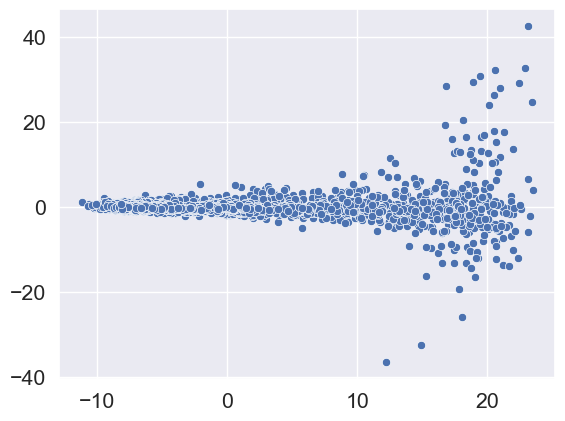

In [52]:
# visualize
# ----------
sns.scatterplot(x = Y_pca[:, 0],  # extract all the elements from the first column
                y = Y_pca[:, 1]); # extract all the elements from the second column

__QUESTION__: What do each point represent? What do the x and y axes represent?

__ANSWER__: Each point represents a word. Explanation for axes are below as a part of the lab:

You might at this point still be confused on what the x- and y- axes represent. Because PCA selects and combines features according to what best describes and models the desired variable, the x and y axes actually **don't have an intuitive meaning on a human level.** PCA's job is to reduce the dimension of the features, and in this case it reduce the 100 features of each word vector to just the 2 that best described the words we modeled on. So, don't worry too much about what the coordinates of each word represents - we just want you to have a general and visual understanding of word vectors and how they may be related to one another on a graph.

On that note, run the following cell. This will label each vector with its respective word. 

**CHALLENGE:** Make sure you know have a clear understanding of each line in the code cell below.

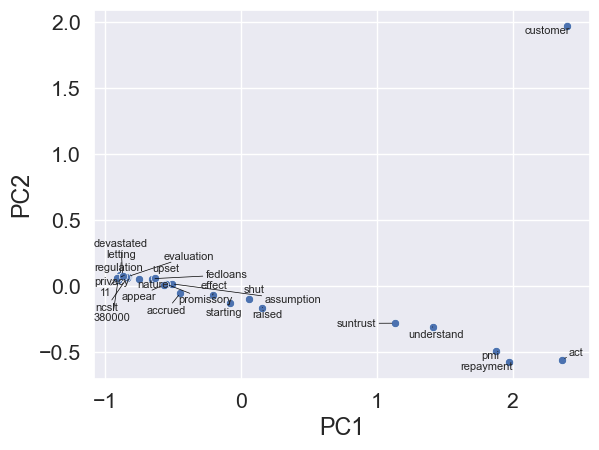

In [53]:
# recreate visualization with points
# ----------

# load libraires
import random
from adjustText import adjust_text

# set seeed
random.seed(10)

# take random sample of 25 word embeddings 
rando = random.sample(list(model.wv.index_to_key), 25) 

# get embeddings
X1 = model.wv.__getitem__(rando)

# initalize PCA
pca1 = PCA(n_components=2)

# fit and transform
result = pca1.fit_transform(X1)

# convert to dataframe 
result_df = pd.DataFrame(result,                   # specify data
                         columns = ['PC1', 'PC2'], # specify column names
                         index = rando)            # set index

# create scatterplot
sns.scatterplot(x = 'PC1',         # specify x-axis
                y = 'PC2',         # specify y-axis
                data = result_df)  # specify data

# initialize empty list
texts = []

# append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], 
                          result_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))
    
# adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

# plot 
plt.show();

## t-SNE

Another popular unsupervised method for summarizing and visualizing word embeddings is [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). We won't get into the details here, but the basic method involves:

1. Estimating the joint probability of the distance between each pair of points, assuming a Gaussian distribution.
2. Project the data into 1-dimension, and then estimate the joint probability of the distance between each pair of points assuming a Student's t-distribution.
3. Use gradient descent to update the second distribution to become similar to the first one.

The basic idea behind this two-step procedure is that we search for the the best lower dimensional representation that gets closest to modeling the original distances in higher dimensional space.

In [54]:
# preprocessing
# ----------

# filter to include only those for which Word2Vec has a vector
vector_list = [model.wv.__getitem__(word) for word in words if word in model.wv.index_to_key]

# create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.index_to_key]

# bind together both lists using zip
word_vec_zip = zip(words_filtered, vector_list)

# create a dictionary and save as a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape

(2759, 100)

Here we initialize a t-SNE model using 2 components as the key hyperparameter. 

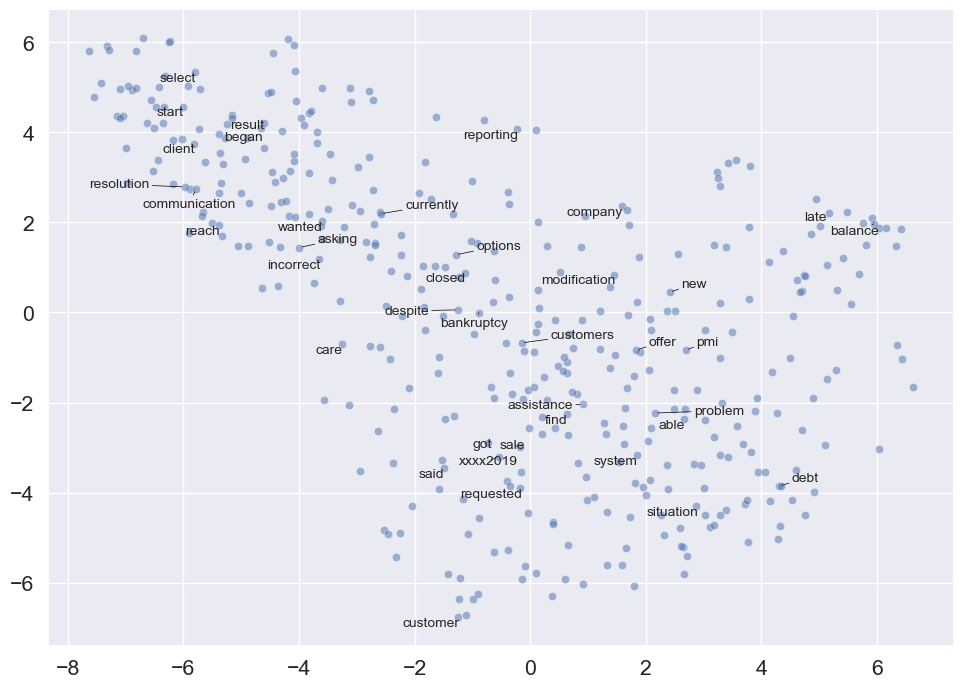

In [55]:
# create t-SNE visualization
# ----------

# initialize t-SNE
tsne = TSNE(n_components = 2,  # specify 2 components
            init = 'random',   # set initalization
            random_state = 10, # set seed
            perplexity = 100)  # set preplexity threshold

# subset to only 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])

# figure specifications
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], 
                y = tsne_df[:, 1], 
                alpha = 0.5)

# initialize empty list
texts = []

# create list of words
words_to_plot = list(np.arange(0, 400, 10))

# append words to list using loop
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], 
                          tsne_df[word, 1], 
                          word_vec_df.index[word], 
                          fontsize = 10))
    
# adjust text to clearlly see labels
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-",
                              color = 'black', 
                              lw = 0.5))

# plot
plt.show()

### Challenge: t-SNE hyperparameters

Try playing with the hyperparameters to see if you can get a different looking plot. Why might this be a problem for interpretability or inference?

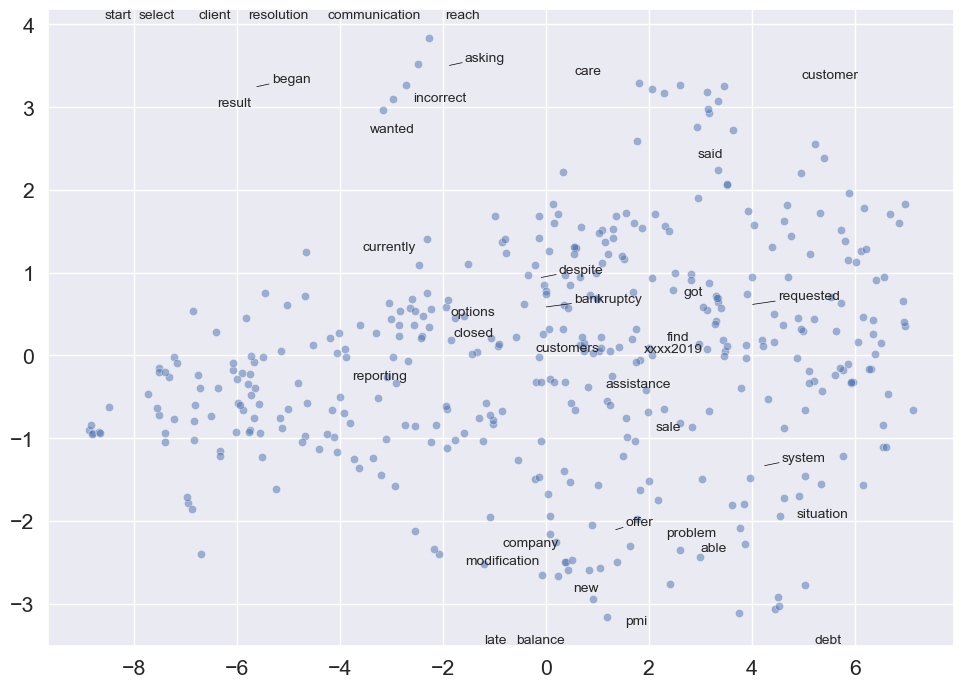

In [57]:
# recreate t-SNE visualization with 3 components
# ----------
tsne = TSNE(n_components = 3,  # specify 3 components  
            init = 'random',   # set initalization 
            random_state = 10, # set seed   
            perplexity = 40)   # set preplexity threshold
   

# subset to only 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])



# figure specifications
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], 
                y = tsne_df[:, 2], 
                alpha = 0.5)


# initialize empty list
texts = []

# create list of words
words_to_plot = list(np.arange(0, 400, 10))

# append words to list using loop
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], 
                          tsne_df[word, 1],
                          word_vec_df.index[word], 
                          fontsize = 10))
    
# adjust text to clearlly see labels   
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-",
                              color = 'black', 
                              lw = 0.5))

# plot 
plt.show()

## Averaging Word Embeddings

You'll notice that right now each token is represented by a 100-dimensional array. If we passed these directly to a classification algorithm our feature space would get very high dimensional quickly! A common practice to avoid this problem is to average the word embeddings somehow. You might have heard of variations of `word2vec` like `sent2vec` and `par2vec` which creates embeddings for sentences and paragraphs, respectively. We'll introduce a similar method below, but one straightforward way to do this without a fancy new model is to simply average the word embeddings at the document level.

To get a sense of how this works, let's look at how many tokens we have in our first document:

In [59]:
# get length
# ----------
len(cfpb['tokens'][0])

223

223 - but remember not all documents will have vectors associated with them if they do not meet word2vec's criteria. Let's see how many we have that are in our model's vocabulary:

In [60]:
# get model's vocabulary
# ----------
doc = [word for word in cfpb['tokens'][0] if word in model.wv.index_to_key]
len(doc)

195

195! Looks like quite a few tokens didn't make it into the model. Let's look at a few that did: 

In [61]:
# look at the first five
# ----------
doc[0:5]

['contacting', 'ocwen', 'mortgage', 'phh', 'mortgage']

Let's also look at the array for 'contacting'. Notice that it is represented by a 100-dimensional array. 

In [62]:
# word embeddings for "contacting"
# ----------
print(model.wv.__getitem__('contacting'))
print(model.wv.__getitem__('contacting').shape)

[-0.15438645  0.11139173  0.0423461  -0.01990378  0.07953268 -0.22532858
  0.03390418  0.19680059 -0.02943929 -0.02090604 -0.08896019 -0.18763153
 -0.05691547  0.11582833  0.09924299 -0.07027543 -0.00344554 -0.17347036
 -0.11450931 -0.2804534   0.03329336  0.0244028   0.10552816 -0.06292938
 -0.01713656  0.02060908  0.00799281 -0.04130865 -0.19192584 -0.015015
  0.22930811  0.02608698  0.00833767 -0.06477918 -0.11277649  0.08920526
  0.00389306 -0.1368925  -0.13367826 -0.29285875 -0.00108436 -0.06043293
 -0.090233   -0.04676668  0.12271277 -0.10184377 -0.04170776  0.04343917
  0.09272827  0.06536065  0.03538954 -0.16687354 -0.00988596 -0.05786114
 -0.09054346  0.04290434 -0.00387454  0.01337937 -0.22676732  0.09327211
  0.07316869  0.09904195  0.05544471  0.03870999 -0.16943747  0.15538062
  0.0512423   0.20480144 -0.20094669  0.0897277  -0.08433386  0.15311058
  0.10652031 -0.09529097  0.12591763  0.14235055  0.06527869 -0.03985436
 -0.10769287 -0.04016771 -0.06082231  0.00792588 -0.1

In [63]:
# find the mean
# ----------
np.mean(model.wv.__getitem__('contacting'))

0.0027242312

Now let's grab the first vector each token and take their mean:

In [64]:
# find the first vector of each token and find their mean
# ----------
# create empty list
first_vec = []

# loop over each document
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
    
# calculate their mean
np.mean(first_vec)

-0.31032002

And then let's do this for every token and document in our corpus:

In [31]:
# create function to do this for every token and document in our corpus
# ----------
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [32]:
# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for puppy in cfpb['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, puppy))
    
# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# print averages
doc_average_embeddings

array([[-0.31032008,  0.23317133,  0.07854156, ..., -0.20592353,
         0.10249326,  0.04218204],
       [-0.30979568,  0.21517237,  0.08415403, ..., -0.1997738 ,
         0.10279309,  0.03945671],
       [-0.27888718,  0.19374187,  0.08417241, ..., -0.17416658,
         0.07393446,  0.02758297],
       ...,
       [-0.33570793,  0.21585064,  0.10334043, ..., -0.22876745,
         0.11560804,  0.02105342],
       [-0.31255895,  0.26460093,  0.06935374, ..., -0.24499062,
         0.11502917,  0.06905693],
       [-0.33346435,  0.2511021 ,  0.0867294 , ..., -0.23343664,
         0.12268724,  0.05712049]], dtype=float32)

Ultimately we get an array with `n` rows and 100 columns:

In [33]:
# find the shape 
doc_average_embeddings.shape

(1000, 100)

## Document averaged work embedding (doc2vec)

Document averaged word embeddings tend to perform well with downstream prediction tasks, but there are other options as well. Here, we'll take a look at Doc2Vec. 

We're getting close to classifying, and this is a good point to do our train/test splits. While normally we recommend waiting to do splits until after all preprocessing is done, in this case it will be easier to do the split now because of the way the `TaggedDocument` class works. Let's take a look:

In [34]:
# preprocessing
# ----------

# intitalize label binarizer
lb_style = LabelBinarizer()

# fit transform
y = cfpb['Product_binary'] = lb_style.fit_transform(cfpb["Product"])

# train/test split
train, test = train_test_split(cfpb,             # specify dataset
                               test_size=0.2,    # specify test size
                               random_state=42)  # set seed
# view
train.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,tokens,Product_binary
29,01/23/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Keep getting calls about your loan,I called Bass and Associates in XX/XX/XXXX and...,NaN,"Bass & Associates, P.C., Attorneys at Law",DC,200XX,NaN,Consent provided,Web,01/23/20,Closed with explanation,Yes,NaN,3506557,"[called, bass, associates, company, claim, stu...",1
535,02/11/20,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I have been working with Premier Student Loan ...,NaN,Premier Student Loan Center,ND,585XX,NaN,Consent provided,Web,02/11/20,Untimely response,No,NaN,3528302,"[working, premier, student, loan, center, , p...",1
695,01/06/20,Mortgage,Other type of mortgage,Trouble during payment process,NaN,Back in the beginning of 2019 ( XXXX ) notific...,Company believes complaint is the result of an...,Ditech Financial LLC,FL,320XX,NaN,Consent provided,Web,01/06/20,Closed with explanation,Yes,NaN,3486795,"[beginning, 2019, , , notification, sent, di...",0
557,04/30/20,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,My loan was sold to this company. They have 'f...,Company has responded to the consumer and the ...,Specialized Loan Servicing Holdings LLC,AZ,852XX,NaN,Consent provided,Web,04/30/20,Closed with explanation,Yes,NaN,3631157,"[loan, sold, company, fees, , disclosed, loan...",0
836,02/15/20,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,"Mortgage is delinquent by {$14000.00}, working...",Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",PA,NaN,Older American,Consent provided,Web,02/15/20,Closed with explanation,Yes,NaN,3532998,"[mortgage, delinquent, 1400000, working, loss,...",0


After we do our train test splits, we apply the `TaggedDocument()` function to every token. This allows us to associate each document with the class that we want to predict later:

In [35]:
# apply tag to each train/test dataset
# ----------

# tag training datatset
cfpb_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'],
                                                         tags=[r.Product_binary]), 
                                axis=1)

# tag testing datatset
cfpb_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], 
                                                       tags=[r.Product_binary]),
                              axis=1)

# view the first row
cfpb_train_tagged[0]

TaggedDocument(words=['contacting', 'ocwen', 'mortgage', 'phh', 'mortgage', 'avail', 'expressed', 'concern', 'extent', 'damage', 'house', 'severe', 'termite', 'infestation', 'mold', 'mildew', 'continued', '2200000', 'dollars', 'mortgage', 'payments', 'house', 'water', 'called', 'backs', 'approved', 'loan', 'refinancing', 'told', 'lender', 'house', 'renovated', 'house', 'flooded', 'continued', 'payments', 'living', 'house', 'deemed', 'uninhabitable', 'unsafe', 'structural', 'integrity', 'house', 'invested', 'walk', 'away', 'property', '\n', 'flood', 'insurance', 'house', '24yrs', '\n', 'submitted', 'pictures', 'damage', 'caused', 'termites', 'thing', 'mortgage', 'companies', 'interested', 'mortgage', 'monthly', 'payments', 'submitted', 'supporting', 'documentation', 'work', 'related', 'injuries', 'sustained', 'job', 'working', 'waiting', 'help', 'restore', 'louisiana', 'program', 'gotten', 'help', 'restore', 'louisiana', 'program', 'fixed', 'house', 'sold', 'choosing', 'told', 'ocwen', 

We're now ready to train our `doc2vec!` One of the key features of gensim is that it natively allows multicore processing - meaning it can take advantage of your CPU cores. Note that this is slightly different from tensorflow that we covered last semester, which also allows GPU acceleration. You can check how many CPU cores you have available: 

In [36]:
# count your cores for processing
# ----------
cores = multiprocessing.cpu_count()
cores

8

[Parallel processing](https://en.wikipedia.org/wiki/Parallel_computing) is an important topic in computational social science - it will be the key to speeding up lots of different operations. In general, we recommend that whenever you use parallel processing you reserve 1 CPU core for your computer's other functions (keeping your browser and other software running), and use the remaining for your task at hand. In this case, doc2vec's training process is an example of [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) meaning that the different CPUs don't need to talk to each other to do their computations. They can independently work and combine the results at the end. In this case, we are working with very few observations (just 1000), but this is a useful technique to keep in mind for your projects and research! 

First we'll train the model (notice the use of the [`tqdm`](https://tqdm.github.io/) library for progerss bars):

In [66]:
# train a Doc2Vec model 
# ----------
# initalize Doc2Vec
model_dbow = Doc2Vec(dm=0,              # training algorithim: distributed bag of words
                     vector_size=300,   # word embedding size
                     negative=5,        # how many negative samples
                     hs=0,              # hierarchical softmax using negative samples
                     min_count=2,       # ignores all words with a total frequency lower than this threshold.
                     sample = 0,        # how much downsampling - 0 means none
                     workers=cores - 1) # how many cores will be used

# apply to training data
model_dbow.build_vocab([x for x in tqdm(cfpb_train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 401416.82it/s]


We'll allow the model to train for 30 iterations (epochs - this is the same as our neural nets lab):

In [67]:
# loop over our data
# ----------
for epoch in range(1,30):
    model_dbow.train(utils.shuffle([x for x in tqdm(cfpb_train_tagged.values)]), 
                     total_examples=len(cfpb_train_tagged.values), 
                     epochs=epoch)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<?, ?it/s]


Finally, we'll define a function that will grab the embeddings for each document:

In [39]:
# grab the embeddings
# ----------
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

## Classification

And finally, let's use logistic regression to see how well our document embeddings do:

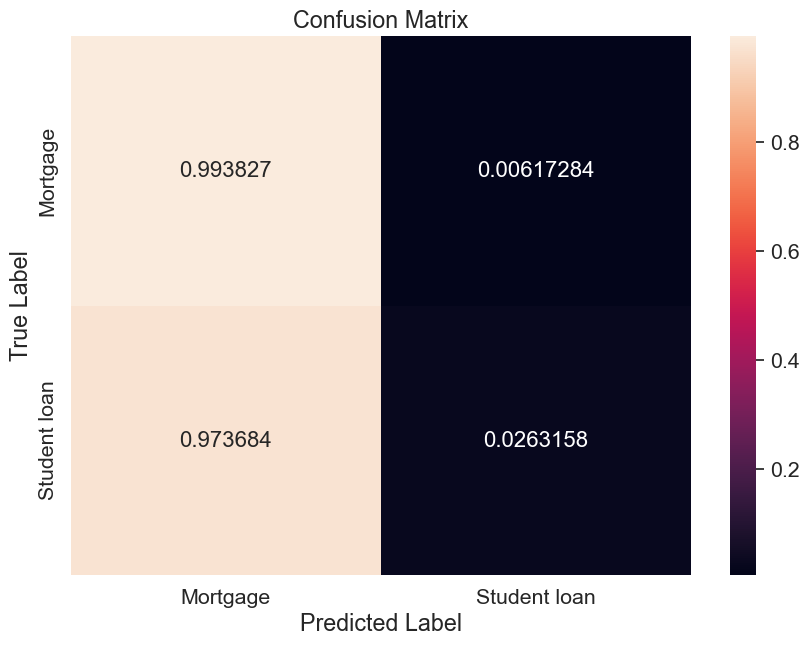

In [40]:
#
# Classifcation model
# ----------------------------------------


# intialize a logit model
# ----------

# split into training
y_train, X_train = vec_for_learning(model_dbow, # specify datasets for split
                                    cfpb_train_tagged)

# split into testing
y_test, X_test = vec_for_learning(model_dbow,  # specify datasets for split
                                  cfpb_test_tagged)

# initalize model
logit_reg = LogisticRegression() # intialize logit model

# fit on training
logit_model = logit_reg.fit(X_train,  # fit to training data
                            y_train)

# predict on test data
y_pred = logit_model.predict(X_test)  # predict on testing data


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, 
                     columns={0: "Mortgage", 1: "Student loan"})

df_cm.index = ["Mortgage", "Student loan"]

# plot specifications
# ----------
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Hmm, not as well as we might think! But this shouldn't be too surprising with a small dataset - word embeddings tend to work best when given lots of data.

# Loading Pre-Trained Embeddings

So far we have been working with embeddings trained on our particular corpus. However, this is not usually standard - as you saw above, word2vec works best when it has lots of data. The problem is that training state-of-the-art models requires intense computational resources. It also has a [large carbon footprint](https://arxiv.org/pdf/1906.02243.pdf). Luckily, we can use pre-trained models like Google News or Stanford's GloVe. Note to run this next chunk of code, you need to have the [GoogleNews embeddings](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) in your "data" directory in this repo.

In [65]:
# load pre-trained Google News model 
# ----------
googlenews_word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', 
                                                                            binary = True) 

We can also tune the Google News embeddings to a domain-specific corpus. This may or may not be necessary depending on how specific or unique you think words in your corpus might be:

In [ ]:
# retrain google on your own corpus
# ----------

# ! NOTE: THIS TAKES A VERY LONG TIME TO RUN - SO WE WON'T RUN IT HERE
# ! BUT WE CAN RE-RUN FROM HERE TO SEE HOW THIS MIGHT ULTIMATELY AFFECT
# ! OUR CLASSIFICATION MODEL



## specify your corpus
#your_corpus = cfpb['tokens']  # Load your corpus here, make sure it's tokenized
#
## initialize Word2Vec model with the same dimensions as the Google News vectors
#word2vec_model = gensim.models.Word2Vec(vector_size=300,    # word embedding size
#                                        window=5,           # window size
#                                        min_count=1,        # ignores words w/ frequency lower than this threshold
#                                        workers=cores - 1)  # how many cores will be used
#
## build vocabulary 
#word2vec_model.build_vocab(your_corpus)
#
## initialize word vectors using the Google News pre-trained vectors
#word2vec_model.wv.vectors = googlenews_word2vec_model.vectors
#
## training model
#word2vec_model.train(your_corpus, 
#                     total_examples=len(your_corpus), 
#                     epochs=5, 
#                     compute_loss=True)

## Challenges

### Challenge Embeddings 

Repeat the exploration we did in the first part where we trained word embeddings with the new Google model. Do you notice any differences? Create document averaged word embeddings and predict our outcome ('Product_binary'). How did this compare to doc2vec?

In [ ]:
# print embeddings for specific word -- "account"
# ----------
print(googlenews_word2vec_model.__getitem__(['account']))

**QUESTION:** Check out the shape of the vectors for 'account', what do you notice?

In [ ]:
# get the shape of the embeddings - what does this tell us?
# ----------
googlenews_word2vec_model.__getitem__(['account']).shape

**ANSWER**: There are 300 elements in this array, which is the number of embeddings in each Google News vector. 

Use the following empty cells to look at what the word embeddings look like for words you think may appear in the text! Keep in mind that even if a word shows up in the text as seen above, a word vector will not be created unless it satisfies all conditions we inputted into the model above. 

In [ ]:
# word 1
# ----------
#googlenews_word2vec_model.__getitem__(['navient'])

**QUESTION:** Did this run as you expected? Why or why not?

**ANSWER:** This no longer runs because `Navient` is not present in the Google News corpus. Why might this be? Because that is a very specific work entered by someone writing a complaint but is not common enough to be captured in Google's training data. 

In [ ]:
# word 2
# ----------
googlenews_word2vec_model.__getitem__(['company'])

In [ ]:
# word 3 
# ----------
googlenews_word2vec_model.__getitem__(['credit'])

As above, the cell directly below will return a list of words that have been turned into word vectors by the model above:

In [ ]:
# return a list of words for which we have calculations
# ----------
words = list(googlenews_word2vec_model.index_to_key) 
print(words[0:100])

`gensim` comes with some handy methods to analyze word relationships. `similarity` will give us a number from 0-1 based on how similar two words are. If this sounds like cosine similarity for words, you'd be right! It just takes the cosine similarity of the high dimensional vectors we input. 

In the following cell, find the similarity between the words `credit` and `debt`. 

**QUESTION:** How does this compare to the model trained on our own small dataset?

In [ ]:
# similarty between credit and debt and compare to above
# ----------
googlenews_word2vec_model.similarity('credit', 
                                     'debt')

**ANSWER:** This seems more sensible than ~0.98. They are related but have clear differences. 

We can also find cosine distance between two clusters of word vectors. Each cluster is measured as the mean of its words:

In [ ]:
# similarity between credit/debt and loan/mortgage
# ----------
googlenews_word2vec_model.n_similarity(['credit','debt'],['loan','mortgage'])

We can find words that don't belong with `doesnt_match` parameter. This finds the mean vector of the words in the `list`, and identifies the furthest away. Try it out. Of the three words in the list `['credit', 'loan', 'student']`, which is the furthest vector from the mean?

In [ ]:
# words that don't match 1
# ----------
googlenews_word2vec_model.doesnt_match(['credit', 'loan', 'student'])

In [ ]:
# words that don't match 2
# ----------
googlenews_word2vec_model.doesnt_match(('pandemic', 'covid', 'bank'))

Let's look at how the Google News model did for this example above: 
$$\vec{house} - \vec{rent} + \vec{loan} = $$

In [ ]:
# vector math with google
# ----------
googlenews_word2vec_model.most_similar(positive=['house', 'loan'], 
                                       negative=['rent'])

### Challenge PCA

Next we will explore the word embeddings of our `text` visually with PCA. We can retrieve __all__ of the vectors from a trained model as follows:

In [ ]:
# retrieve all vectors
# ----------

# create list of model_words
model_words = [word for word in doc if word in model.wv.index_to_key and word in googlenews_word2vec_model.index_to_key]

# get word embeddings of model_words and save to a new object
X = googlenews_word2vec_model.__getitem__(model_words)

# print shape and words
print(X.shape) # 181 words, 300 element vectors 
print(model_words)

As we do with non-text features, we want to standardize X so that all features have the same scale. Do this by creating a `StandardScaler()`, then run its `fit_transform method` on X. 

In [ ]:
# scale the data
# ----------
X_std = StandardScaler().fit_transform(X)

In [ ]:
# fit a PCA 
# ----------
# initalize model and set parameters
pca = PCA(n_components=2) # set n_components to 2 to graph in 2-D

# fit and transform the standardized data
Y_pca = pca.fit_transform(X_std)

In [ ]:
# visualize
# ----------
sns.scatterplot(x = Y_pca[:, 0], # extract all the elements from the first column
                y = Y_pca[:, 1]) # extract all the elements from the second column

In [ ]:
# recreate the visualization with 2 components
# ----------

# set random seed
random.seed(10)

# sample 25 words
rando_words = random.sample(model_words, 25) 

# get embeddings
X1 = model.wv.__getitem__(rando_words)

# initalize PCA
pca1 = PCA(n_components=2)

# fit and transform
result = pca1.fit_transform(X1)

# create dataframe
result_df = pd.DataFrame(result,               
                         columns = ['PC1', 'PC2'], 
                         index = rando)

# create scatterplot
sns.scatterplot(x = 'PC1',        # specify x-axis
                y = 'PC2',        # specify y-axis
                data = result_df) # specify dataset

# initialize empty list
texts = []

# append words to list - FOR SOME REASON, THIS LINE WILL NOT RUN. YOU GET THE SAME OUTPUT JUST W/O THE LABELS
#for word in result_df.index:
#    texts.append(plt.text(result_df.loc[word, 'PC1'], 
#                          result_df.loc[word, 'PC2'], 
#                          word, 
#                          fontsize = 8))

# plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

plt.show()

## Averaging Word Embeddings

And then let's do this for every token and document in our corpus:

In [ ]:
# create function to iterate over every token and document in our corpus
# ----------
def document_vector(model, doc):
    doc = [word for word in doc if word in model.index_to_key]
    return np.mean(model.__getitem__(doc), axis=0)

In [ ]:
# create an array for the size of the corpus
# ----------
# create empty list
empty_list_embeddings_means = []

# loop over each each token
for doc in cfpb['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(googlenews_word2vec_model, doc))

# convert the list to array
doc_average_embeddings = np.array(empty_list_embeddings_means) 

# print averages
doc_average_embeddings

### Challenge: Classification

Let's run a classificaiton model using the Google News trained model. 

**QUESTION:** How does this pre-trained library do compared to our first model fit to our own data? Why do you think this is?

In [ ]:
# convert word embeddings into dataframe
# ----------
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

In [ ]:
#
# Classifcation model
# ----------------------------------------


# specify logit model
# ----------

# create label
y = cfpb['Product_binary']

# split into training
X_train, X_test, y_train, y_test = train_test_split(word2vec_features_df, # specify features
                                                    y,                    # specify labels
                                                    train_size = .80,     # specify training split
                                                    test_size=0.20,       # specify test split
                                                    random_state = 10)    # set seed
# inititialize a model
logit_reg = LogisticRegression()

# fit on training
logit_model = logit_reg.fit(X_train, 
                            y_train.ravel())

# predict on test data
y_pred = logit_model.predict(X_test)

# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, columns={0: "Checking or savings account", 
                                         1: "Student loan"})

df_cm.index = ["Checking or savings account", "Student loan"]


# plot specifications
# ----------

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Google Document Averaged Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**ANSWER:** This model, which is traine on the Google News library, does much better the the model trained just on our data. This is likely because the Google News library has much larger training set data and therefore the model has better learned word associations than can be learned on our small dataset.  

Uncomment the script code above to re-train the Google News model on your data and re-run to see how it performs in comparison. How do you think it will do?

It should perform worse becuase it is a much smaller corpus and therefore does not learn the word meanings quite as well. 

# Discussion

You've now had a gentle introduction to word embeddings! There are a few major lessons here.

- Word embeddings are powerful and capture a lot of context that frequency based embeddings do not. However, this isn't perfect! 
- As with any machine learning application, your choice of model and hyperparameters can matter quite a lot. In this case, some of our simpler featurizations and models actually did better than word embeddings, but this won't always be true. 
- It is also worth learning more about other embeddings like [GloVe](https://nlp.stanford.edu/projects/glove/), transformer based models like [BERT](https://arxiv.org/abs/1810.04805) and deep learning approaches like [ELMo](https://arxiv.org/abs/1802.05365).

---
Notebook developed by Aniket Kesari. Some materials borrowed from [LS123: Data, Prediction, and Law](https://github.com/Akesari12/LS123_Data_Prediction_Law_Spring-2019/blob/master/labs/Word%20Embedding/LEGALST-190%20Word%20Embedding%20SOLUTIONS.ipynb). Modified by Prashant Sharma (2023) and annotated by Kasey Zapatka (2024).